In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from string import digits

import seaborn as sn
import matplotlib.pyplot as plt

In [900]:
iso_df = pd.read_csv('../../data/raw/iso_3digit_alpha_country_codes.csv', low_memory=False)
airsavvi = pd.read_csv('../../data/tidy/airsavvi_list.csv')
deterministic = pd.read_csv('../../data/raw/deterministic_wdi.csv', low_memory=False)
cases = pd.read_csv('../../data/raw/confirmed_cases_global.csv', low_memory=False)
deaths = pd.read_csv('../../data/raw/covid_deaths_global.csv', low_memory=False)
activity = pd.read_csv('../../data/raw/google_activity.csv', low_memory=False)

In [901]:
iso_exclude = ['ALB', 'ISL', 'MAC', 'HKG', 'ROU', 'TWN'] #partially missing data

def series_lower(s):
    return s.str.lower().str

def country_matching(substring):
    remove_digits = str.maketrans('', '', digits)
    substring_lower  = substring.lower()
    iso_lower = series_lower(iso_df['Definition'])
    if substring == 'United States' or substring == 'US' or substring == 'United States of America':
        return 'USA'
    elif substring == 'Russia (Soviet Union)':
        return 'RUS'
    elif substring == 'India':
        return 'IND'
    elif substring == 'Turkey (Ottoman Empire)':
        return 'TUR'
    elif substring == 'Taiwan*':
        return 'TWN'
    elif substring == 'Republic of Korea' or substring == 'Korea, Republic of' or substring == 'Korea, South' or substring == 'South Korea':
        return 'KOR'
    elif substring == 'Vietnam, Democratic Republic of':
        return 'VNM'
    elif substring == 'Czech Republic' or substring == 'Czechia':
        return 'CZE'
    elif substring == 'German Federal Republic':
        return 'DEU'
    elif substring == 'Italy/Sardinia':
        return 'ITA'
    elif substring == 'Cambodia (Kampuchea)':
        return 'KHM'
    elif iso_lower.contains(substring_lower).any():
        return iso_df['Code_Value'].loc[iso_lower.find(substring_lower) != -1].to_string().translate(remove_digits).strip()
    else:
        return "N/A"
        
def set_sort_idx(df, idx):
    df = df.set_index(idx)
    df = df.sort_index()
    return df

In [902]:
airsavvi['iso'] = airsavvi['country'].apply(lambda x: country_matching(x))

In [903]:
#Retain vars of interest (economic indicators)
deterministic['iso'] = deterministic['country'].apply(lambda x: country_matching(x))
deterministic = deterministic[deterministic.iso.apply(lambda x: x not in iso_exclude)]

deterministic = deterministic[['iso', 'year','pop_WDI_PW', 'gdp_WDI_PW', 'gdppc_WDI_PW', 'growth_WDI_PW', 'pop_WDI', 'pop_den_WDI',
                              'pop_urb_WDI', 'pop0_14_WDI', 'workingpop_WDI']]    

deterministic = deterministic.loc[deterministic['iso'].isin(airsavvi['iso'])]

C:\Users\nasko\anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [904]:
#Set iso as index, sort by index alphabetically
deterministic = set_sort_idx(deterministic, 'iso')

In [905]:
#JHU tracking new COVID cases
cases['iso'] = cases["Country/Region"]  .apply(lambda x: country_matching(x))
cases = cases[cases.iso.apply(lambda x: x not in iso_exclude)]

#Aggregating new covid cases based on subregional breakdown
total_cases = cases.groupby(by = ['iso']).sum()
total_cases = total_cases.sort_index()

#Subset of countries with airsavvi flight data from Feb 15 to Aug 31
total_cases = total_cases.loc[total_cases.index.isin(airsavvi['iso'])]
total_cases = total_cases.loc[:, '2/15/2020':'8/31/2020']

len(total_cases)

57

In [906]:
#JHU tracking COVID deaths
deaths['iso'] = deaths['Country/Region'].apply(lambda x: country_matching(x))
deaths = deaths[deaths.iso.apply(lambda x: x not in iso_exclude)]

#Aggregating covid deaths based on subregional breakdown
total_deaths = deaths.groupby(by = ['iso']).sum()
total_deaths = total_deaths.sort_index()

#Subset of countries with airsavvi flight data from Feb 15 to Aug 31
total_deaths = total_deaths.loc[total_deaths.index.isin(airsavvi['iso'])]
total_deaths = total_deaths.loc[:, '2/15/2020':'8/31/2020']

len(total_deaths)

57

In [907]:
#Concatenate cases and deaths
frames = [total_cases, total_deaths]
result = pd.concat(frames, keys=['cases', 'deaths'])

In [908]:
activity = activity.rename(columns={"country_region": "country",
                        "country_region_code": "iso", #multi-index label consistency across different sources
                        "retail_and_recreation_percent_change_from_baseline": "retail", 
                        "grocery_and_pharmacy_percent_change_from_baseline": "grocery",
                        "parks_percent_change_from_baseline": "parks",
                        "transit_stations_percent_change_from_baseline": "transit",
                        "workplaces_percent_change_from_baseline": "workplaces",
                        "residential_percent_change_from_baseline": "residential"})

activity['iso'] = activity["country"].apply(lambda x: country_matching(x))
activity = activity[activity.iso.apply(lambda x: x not in iso_exclude)]

activity = activity.loc[activity['iso'].isin(airsavvi['iso'])]
activity = activity[['iso', 'date','retail', 'grocery', 'parks', 'transit', 'workplaces', 'residential']]

#Aggregating baselines by activity type
unpivoted = pd.melt(activity, id_vars=['iso', 'date'], value_vars = ['retail', 'grocery', 'parks', 'transit', 'workplaces', 'residential'], 
        var_name="activity", 
        value_name="percent_change")

unpivoted = unpivoted.pivot_table(index=['iso','activity'],columns='date',values='percent_change')

#Limit dataset to Feb 15-Aug 31
unpivoted = unpivoted.loc[:, '2020-02-15':'2020-08-31']

unpivoted.head()

date             2020-02-15  2020-02-16  2020-02-17  2020-02-18  2020-02-19  \
iso activity                                                                  
ARE grocery             4.0         4.0         1.0         1.0         0.0   
    parks               5.0         4.0         5.0         5.0         4.0   
    residential         1.0         1.0         1.0         1.0         1.0   
    retail              0.0         1.0        -1.0        -2.0        -2.0   
    transit             0.0         1.0         1.0         0.0        -1.0   

date             2020-02-20  2020-02-21  2020-02-22  2020-02-23  2020-02-24  \
iso activity                                                                  
ARE grocery             1.0         2.0         2.0         3.0         0.0   
    parks               6.0         6.0         4.0         3.0         5.0   
    residential         1.0         1.0         1.0         1.0         1.0   
    retail             -2.0        -3.0        -2.0        -1.0        -3.0   
    transit             1.0         0.0        -2.0        -1.0        -1.0   

date             ...  2020-08-22  2020-08-23  2020-08-24  2020-08-25  \
iso activity     ...                                                   
ARE grocery      ...        -9.0         1.0       -10.0        -8.0   
    parks        ...       -43.0       -37.0       -42.0       -41.0   
    residential  ...         8.0        22.0        10.0        10.0   
    retail       ...       -23.0       -19.0       -25.0       -24.0   
    transit      ...       -44.0       -53.0       -42.0       -41.0   

date             2020-08-26  2020-08-27  2020-08-28  2020-08-29  2020-08-30  \
iso activity                                                                  
ARE grocery            -7.0        -5.0       -11.0        -5.0         2.0   
    parks             -41.0       -42.0       -55.0       -46.0       -38.0   
    residential        10.0        11.0        10.0         8.0         9.0   
    retail            -23.0       -22.0       -30.0       -23.0       -18.0   
    transit           -41.0       -41.0       -47.0       -42.0       -40.0   

date             2020-08-31  
iso activity                 
ARE grocery            -3.0  
    parks             -40.0  
    residential        10.0  
    retail            -21.0  
    transit           -41.0  

[5 rows x 199 columns]

In [909]:
#Set iso as index, sort by index alphabetically
activity = set_sort_idx(activity, 'iso')

In [887]:
#Print output in tidy
deterministic.to_csv('../../data/tidy/deterministic.csv')
result.to_csv("../../data/tidy/cases_deaths_concat.csv")
unpivoted.to_csv("../../data/tidy/google_activity.csv")

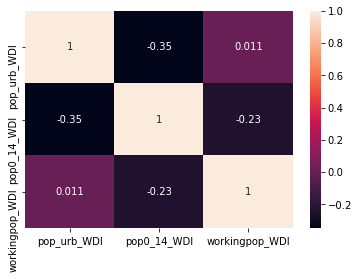

In [910]:
#Correlation matrix - deterministic vars
cor_matrix = deterministic.iloc[:,7:].corr()

sn.heatmap(cor_matrix, annot=True)
plt.show()